# Training LaTeX OCR model Experiment Zone

## Stuffs...



In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

# folder path containing the images
folder_path = "D:\im2latex_data\Euler_fonts\Euler_train_20k"

target_shape = (896, 384)

# initialize a list to store all the images
images = []

# loop through the files in the folder
for filename in os.listdir(folder_path):
    # load the image

    image = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_UNCHANGED)
    
    height, width = image.shape[0], image.shape[1]
    try:
        if image is not None:
            #check if image size is in smaller or equal to target size
            if height <= target_shape[1] and width <= target_shape[0]:

                # convert the image to grayscale
                im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                

                new_im = np.full((target_shape[1], target_shape[0], 3), 255, dtype=np.uint8)
                new_im[:height,:width,:] = im
                #add the image to the list
                images.append(new_im)

    except:
        continue

    
# # convert the list of images into a single array
# images = np.concatenate(images, axis=0)

# # calculate the distribution of pixel values
# values, counts = np.unique(images, return_counts=True)

# # plot the distribution using a bar plot
# plt.bar(values, counts, width=0.9, align='center')
# plt.title("Pixel Value Distribution")
# plt.xlabel("Pixel Value")
# plt.ylabel("Count")
# plt.show()

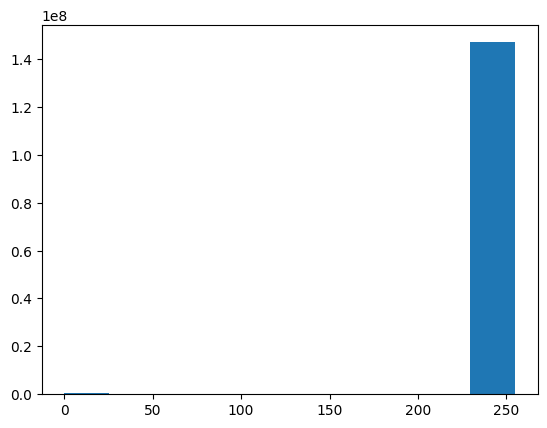

In [19]:
import random
random_images = random.sample(images, 100)

# concatenate the pixels of the subset images into one array
all_pixels = np.concatenate([image.ravel() for image in random_images])

# plot the distribution of the pixels
plt.hist(all_pixels)
plt.show()

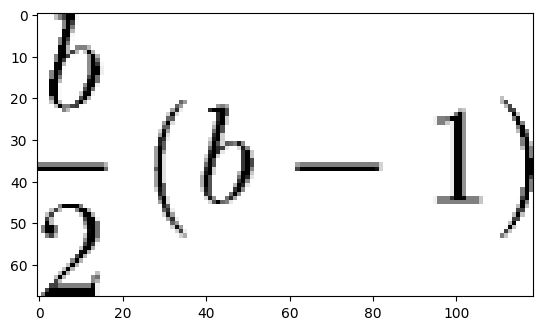

In [5]:
import cv2
import matplotlib.pyplot as plt
im = cv2.imread(r"D:\im2latex_data\im2latex-170k\sorted_images\0000017.png", cv2.IMREAD_UNCHANGED)
#Image data of dtype object cannot be converted to float
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

plt.imshow(im)

## Testing new Loss function

In [1]:
import yaml
import torch
from pix2tex.dataset.dataset import Im2LatexDataset
from transformers import PreTrainedTokenizerFast
from pix2tex.models import get_model
from munch import Munch

config_pth = r'D:\LaTeX_OCR-Vinh_MyRepo\LaTeX-ViT\checkpoints_vit\Hybrid_im100k\config.yaml'
tokenizer_pth = r'D:\LaTeX_OCR-Vinh_MyRepo\LaTeX-ViT\pix2tex\model\dataset\tokenizer.json' 
model_pth = ''

with open(config_pth) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
args = Munch(config)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args.device = device
args.wandb = False

tokenizer = PreTrainedTokenizerFast(tokenizer_file=tokenizer_pth)

#get model
model = get_model(args)

print(args.tokenizer)
# model.load_state_dict(torch.load(model_pth, map_location=device))

data = r'D:\LaTeX_OCR-Vinh_MyRepo\LaTeX-ViT\pix2tex\model\dataset\train.pkl'
dataloader = Im2LatexDataset().load(data)
dataloader.update(**args, test=False)

microbatch = args.get('micro_batchsize', -1)
if microbatch == -1:
    microbatch = args.batchsize

c:\Users\Admins\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


D:\LaTeX_OCR-Vinh_MyRepo\LaTeX-ViT\pix2tex\model\dataset\tokenizer.json


In [2]:
def detokenize(tokens, tokenizer):
    toks = [tokenizer.convert_ids_to_tokens(tok) for tok in tokens]
    for b in range(len(toks)):
        for i in reversed(range(len(toks[b]))):
            if toks[b][i] is None:
                toks[b][i] = ''
            toks[b][i] = toks[b][i].replace('Ġ', ' ').strip()
            if toks[b][i] in (['[BOS]', '[EOS]', '[PAD]']):
                del toks[b][i]
    return toks

In [11]:
#create dummy pred vector
import itertools

def check(ops):
    # String to be evaluated
    expr = "8 {} 8 {} 8".format(*ops)
    
    # Avoiding division by zero
    if "/ 0" in expr:
        return False

    # Evaluation respecting order of operations
    result = eval(expr)

    return result == 15

# All possible combinations of operators
operators = list(itertools.product(['+', '-', '*', '/'], repeat=2))

for ops in operators:
    if check(ops):
        print(' '.join(map(str, ops)))
        break


In [23]:
import itertools

def apply_operator(op, a, b):
    if op == '+':
        return a + b
    elif op == '-':
        return a - b
    elif op == '*':
        return a * b
    elif op == '/':
        # Handle division by zero
        if b == 0:
            return None
        else:
            return a / b
    else:
        raise ValueError("Invalid operator")

def check(numbers, target, ops, pows):
    numbers = [numbers[i]**pows[i] for i in range(len(numbers))]
    
    result = numbers[0]
    for i in range(1, len(numbers)):
        result = apply_operator(ops[i-1], result, numbers[i])
        if result is None:
            return False

    return result == target

def solve(numbers, target):
    # All possible combinations of operators
    operators = list(itertools.product(['+', '-', '*', '/'], repeat=len(numbers)-1))

    # Range of exponents to test
    exponents = list(itertools.product(range(-3, 3), repeat=len(numbers)))

    found = False
    for ops in operators:
        for pows in exponents:
            if check(numbers, target, ops, pows):
                print('Numbers: ', ' '.join(map(str, numbers)))
                print('Target: ', target)
                print('Operators: ', ' '.join(map(str, ops)))
                print('Exponents: ', ' '.join(map(str, pows)))
                found = True
                break
        if found:
            break
    if not found:
        print('No solution found!')

# Example usage
solve([8, 8, 8], 7)

Numbers:  8 8 8
Target:  7
Operators:  - *
Exponents:  -1 -2 2


In [3]:
dset = iter(dataloader)
for i, (seq, im) in enumerate(dset):
    if seq is not None and im is not None:
        for j in range(0, len(im), 1):
            tgt_seq, tgt_mask = seq['input_ids'][j:j+microbatch].to(device), seq['attention_mask'][j:j+microbatch].bool().to(device)
            # print('tgt_seq shape: ', tgt_seq.shape)
            print('seq_ids:', seq['input_ids'])
            print('tgt_seq: ', tgt_seq)
            print('truth_labels:' , detokenize(seq['input_ids'], dataloader.tokenizer))
            # print('tgt_mask shape: ', tgt_mask.shape)
            print('tgt_mask: ', tgt_mask)
            break

seq_ids: tensor([[  1,  59, 340,  90,  33,   7, 297,  92,   2,   0,   0,   0,   0,   0],
        [  1,  64, 232, 113,  90,  19, 111,  18, 160, 231, 438,  21,  92,   2],
        [  1,  23,  59, 126,  90, 192,  92,   2,   0,   0,   0,   0,   0,   0],
        [  1,  24,  59, 126,  90,  22, 135, 142,   2,   0,   0,   0,   0,   0],
        [  1,  64,  59, 126,  90, 274,  92,   2,   0,   0,   0,   0,   0,   0],
        [  1,  19,  64,  59, 126,  90,  18,  92,   2,   0,   0,   0,   0,   0],
        [  1,  18,  59, 126,  90, 596,  92,   2,   0,   0,   0,   0,   0,   0]])
tgt_seq:  tensor([[  1,  59, 340,  90,  33,   7, 297,  92,   2,   0,   0,   0,   0,   0],
        [  1,  64, 232, 113,  90,  19, 111,  18, 160, 231, 438,  21,  92,   2],
        [  1,  23,  59, 126,  90, 192,  92,   2,   0,   0,   0,   0,   0,   0],
        [  1,  24,  59, 126,  90,  22, 135, 142,   2,   0,   0,   0,   0,   0],
        [  1,  64,  59, 126,  90, 274,  92,   2,   0,   0,   0,   0,   0,   0],
        [  1,  19,  

In [28]:
import yaml
import cv2
import numpy as np
import torch

from transformers import PreTrainedTokenizerFast
from pix2tex.dataset.transforms import test_transform
from pix2tex.models import get_model
from pix2tex.utils import post_process, token2str
from munch import Munch


config_pth = r"D:\LaTeX_OCR-Vinh_MyRepo\Models\ViT-SingleGPU\config.yaml"
tokenizer_pth = r"D:\LaTeX_OCR-Vinh_MyRepo\Models\ViT-SingleGPU\weai_tokenizer.json"
model_pth = r"D:\LaTeX_OCR-Vinh_MyRepo\Models\ViT-SingleGPU\ViT-SingleGPU_e11_step9979_test.pth"

with open(config_pth) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
args = Munch(config)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args.device = device
args.wandb = False

tokenizer = PreTrainedTokenizerFast(tokenizer_file=tokenizer_pth)

#get model
model = get_model(args)
model.load_state_dict(torch.load(model_pth, map_location=device))
model.eval()

def pad_w(img, pad_w):
    left_pad =32
    right_pad = pad_w + 16
    return np.copy(np.pad(img, ((0, 0), (left_pad, right_pad), (0,0)), mode='constant', constant_values=255))

def pad_h(img, pad_h):
    top_pad = 32
    bottom_pad = pad_h + 16
    return np.copy(np.pad(img, ((top_pad, bottom_pad), (0, 0), (0,0)), mode='constant', constant_values=255))


def detokenize(tokens, tokenizer):
    toks = [tokenizer.convert_ids_to_tokens(tok) for tok in tokens]
    for b in range(len(toks)):
        for i in reversed(range(len(toks[b]))):
            if toks[b][i] is None:
                toks[b][i] = ''
            toks[b][i] = toks[b][i].replace('Ġ', ' ').strip()
            if toks[b][i] in (['[BOS]', '[EOS]', '[PAD]']):
                del toks[b][i]
    return toks

#define a predict funciton:
#input: base64 encoded image

def predict(img):
    # img = base64.b64decode(img)
    # im = cv2.imdecode(np.frombuffer(img, np.uint8), cv2.IMREAD_UNCHANGED)
    im = cv2.imread(img, cv2.IMREAD_UNCHANGED)
    height, width = im.shape[0], im.shape[1]
    
    # print(height, width)

    pad_width, pad_height = 0, 0
    if height % 16 != 0:
        pad_height = 16 - (height % 16)
        im = pad_h(im, pad_height)

    if width % 16 != 0:
        pad_width = 16 - (width % 16)
        im = pad_w(im, pad_width)

    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    # print(im.shape)

    img_pred = test_transform(image=im)['image'][:1].unsqueeze(0)
    # print(img_pred.shape)

    gen = model.generate(img_pred.to(args.device), temperature=args.get('temperature', .9)) #tensor
    print(gen)

    dec = detokenize(gen, tokenizer)[0] #list of str
    print(dec)

    pred = post_process(token2str(gen, tokenizer)[0]) #str
    print(pred)
    return gen, dec, pred

In [29]:
gen, dec, pred = predict(r"D:\im2latex_data\Euler_fonts\Euler_private_test\000014.png")

x shape:  torch.Size([1, 63, 256])
tensor([[ 88,  65,  19, 210, 173,  93,  21, 169,  22,  95,   2]])
['v', '_', '1', '=\\', 'dfrac', '{', '3', '}{', '4', '}']
v_1=\dfrac{3}{4}


In [30]:
gen

tensor([[ 88,  65,  19, 210, 173,  93,  21, 169,  22,  95,   2]])

In [33]:
enc = tokenizer.encode(r"\hat { \omega } _ { \bar { s } | 2 } ^ { \phantom { \mu | A } 1 } = 0 .")

In [35]:
tokenizer.decode(gen[0])

'v _ 1 =\\ dfrac { 3 }{ 4 } [EOS]'

In [32]:
pred

'v_1=\\dfrac{3}{4}'

In [37]:
from Levenshtein import distance

ImportError: cannot import name 'distance' from 'Levenshtein' (unknown location)